In [2]:
from scipy.interpolate import RegularGridInterpolator
import numpy as np

material_law = 'orthotropic'
nrows, ncols = 100, 120

# Load solution
data_dir = "data_fem"
data_name = f"{material_law}_{nrows}x{ncols}"
data_path = f"{data_dir}/{data_name}"
full_path = data_path + ".dat"

data = np.loadtxt(full_path, delimiter=" ")
n_rows, n_cols = map(int, full_path.replace('.dat', '').split('_')[-1].split('x'))

x_val      = data[:, 0]
y_val      = data[:, 1]
u_val = data[:, 2:4]
stress_val = data[:, 7:10]

solution_val = np.hstack((u_val, stress_val))

# Interpolate solution
x_grid = np.unique(x_val)
y_grid = np.unique(y_val)

interpolators = []
for i in range(solution_val.shape[1]):
    interp = RegularGridInterpolator((x_grid, y_grid), solution_val[:, i].reshape(n_rows, n_cols).T)
    interpolators.append(interp)

solution_fn = lambda x, y: np.array([interp((x, y)) for interp in interpolators]).T

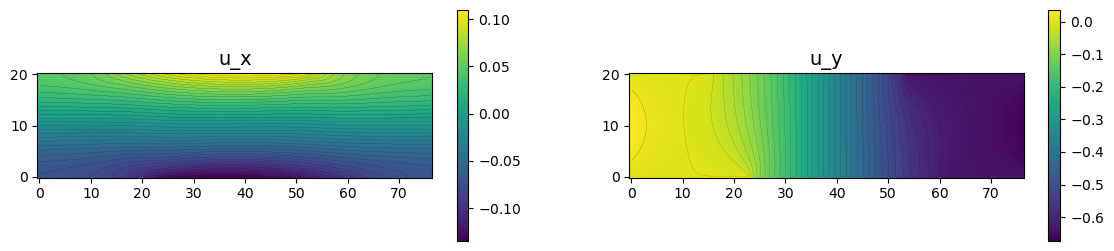

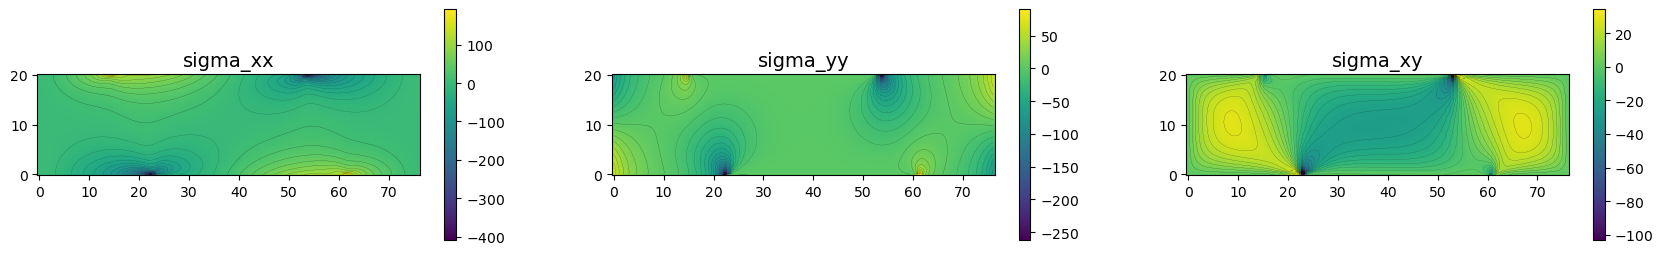

In [6]:
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Geometry parameters (mm)
J1S, J1L = 15.0, 23.0    # left clamp lengths
J2S, J2L = 15.0, 23.0    # right clamp lengths
gauge    = 30.0          # central gauge length
w        = 20.0          # specimen height
t        =  2.3          # thickness depth
L     = gauge + J1L + J2L  # total length = 76.0 mm
u_right = -0.637382 # right clamp displacement from FEM simulation

def pcolor_plot(AX, X, Y, C, title, colormap="viridis", set_axis='on', colorbar=True, contour=True, n_levels=40, **kwargs):
    """
    Plots a pcolor plot with optional contour lines.
    
    Parameters:
        AX (matplotlib.axes): The axis to plot on.
        X, Y (2D array): Grid coordinates.
        C (2D array): Scalar field to plot.
        title (str): Plot title.
        colormap (str or Colormap): Colormap to use.
        set_axis (str): 'on' or 'off' to control axis visibility.
        colorbar (bool): Whether to display a colorbar.
        contour (bool): If True, adds contour lines.
        n_levels (int): Number of contour levels.
        kwargs: Optional `cmin` and `cmax` for color limits.
    """
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, 3))

    cmin = kwargs.get("cmin", None)
    cmax = kwargs.get("cmax", None)

    im = AX.pcolormesh(X, Y, C, cmap=colormap, shading='auto', vmin=cmin, vmax=cmax)

    if contour:
        levels = np.linspace(np.min(C) if cmin is None else cmin,
                             np.max(C) if cmax is None else cmax,
                             n_levels)
        AX.contour(X, Y, C, levels=levels, colors='k', linewidths=0.1)

    AX.set_aspect("equal", "box")
    AX.axis(set_axis)
    AX.set_title(title, fontsize=14)

    if colorbar:
        fig = AX.get_figure()
        fig.colorbar(im, ax=AX, format=formatter)

    return im

# Check interpolation
n_plot_points = (100,77)
full_region = True

x_plot = np.linspace(0, L, n_plot_points[0]) if full_region else np.linspace(J1L, J1L + gauge, n_plot_points[0])
y_plot = np.linspace(0, w, n_plot_points[1])
X, Y = np.meshgrid(x_plot, y_plot)
X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

solution_plot = solution_fn(X_grid[:, 0], X_grid[:, 1])

fig, ax = plt.subplots(1, 2, figsize=(14, 3))
im = pcolor_plot(ax[0], X, Y, solution_plot[:,0].reshape(X.shape), "u_x")
im = pcolor_plot(ax[1], X, Y, solution_plot[:,1].reshape(X.shape), "u_y")

fig, ax = plt.subplots(1, 3, figsize=(21, 3))
im = pcolor_plot(ax[0], X, Y, solution_plot[:,2].reshape(X.shape), "sigma_xx")
im = pcolor_plot(ax[1], X, Y, solution_plot[:,3].reshape(X.shape), "sigma_yy")
im = pcolor_plot(ax[2], X, Y, solution_plot[:,4].reshape(X.shape), "sigma_xy")

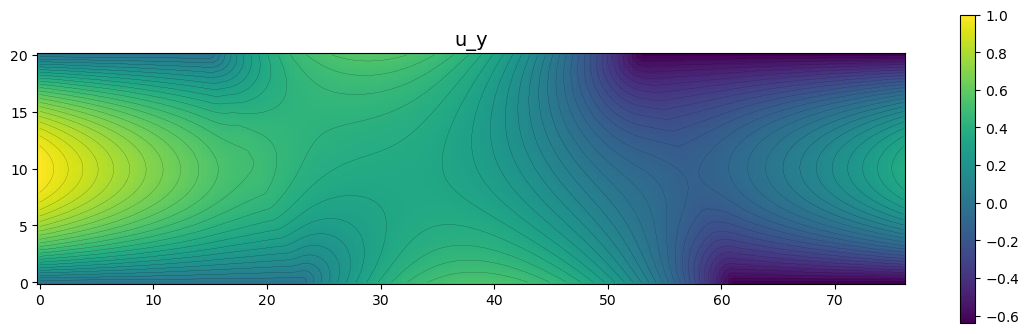

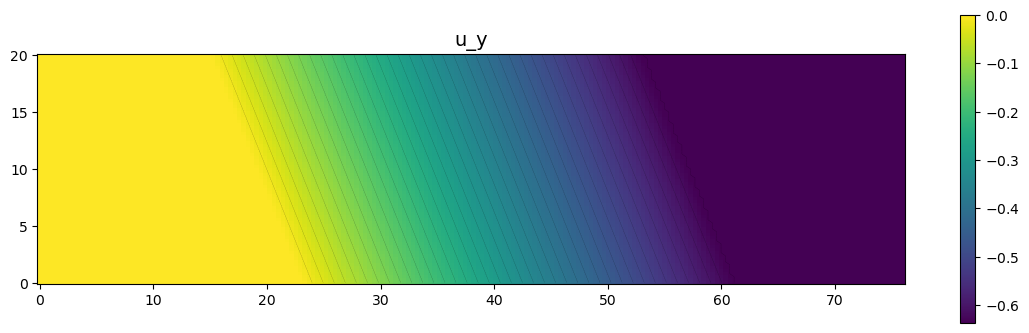

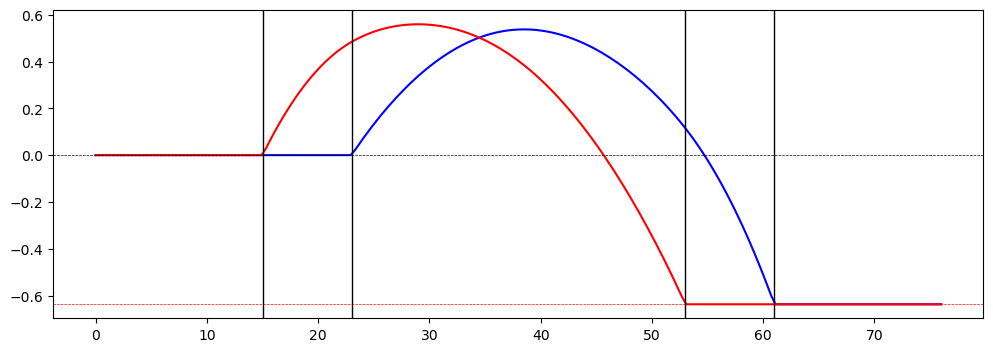

In [15]:
#check hard bc with 
import jax
import jax.numpy as jnp
from typing import List, Tuple, Literal

# Check interpolation
n_plot_points = (200,77)
full_region = True

x_plot = jnp.linspace(0, L, n_plot_points[0]) if full_region else np.linspace(J1L, J1L + gauge, n_plot_points[0])
# x_plot = np.linspace(0, J1S, n_plot_points[0])
y_plot = jnp.linspace(0, w, n_plot_points[1])
X, Y = jnp.meshgrid(x_plot, y_plot)
X_grid = jnp.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

def boundary_constraint_factor(
    x1: jnp.ndarray,
    x2: jnp.ndarray,
    segments: List[Tuple[Tuple[float,float], Tuple[float,float]]],
    smoothness: Literal["C0", "C0+"] = "C0",
) -> jnp.ndarray:
    """
    x1, x2 : (n,) arrays of coordinates
    segments: list of ((xA,yA),(xB,yB))
    smoothness: "C0" = min distance, "C0+" = product of distances
    returns: (n,1) array
    """
    # helper: distance from (x1,x2) to segment A→B
    def _dist(A, B):
        xA, yA = A; xB, yB = B
        vx, vy = xB - xA, yB - yA
        # vector A→P
        px = x1 - xA
        py = x2 - yA
        t = jnp.clip((px*vx + py*vy) / (vx*vx + vy*vy), 0.0, 1.0)
        qx = xA + t*vx
        qy = yA + t*vy
        return jnp.hypot(x1 - qx, x2 - qy)[:, None]

    # build (n, m) matrix of distances
    D = jnp.hstack([ _dist(A, B) for A, B in segments ])

    raw = jnp.min(D, axis=1, keepdims=True)    if smoothness=="C0" else jnp.prod(D, axis=1, keepdims=True)
    return raw.flatten() / raw.max()

def Uy_bc(x1, x2, J1L, J1S, J2L, J2S, L, w, U,
          coord_normalization=False):
    if coord_normalization:
        J1L, J1S, J2L, J2S, L = [v/L for v in (J1L, J1S, J2L, J2S, L)]
    t     = x2 / w
    start = J1L + (J1S - J1L) * t
    end   = (L - J2S) + ((L - J2L) - (L - J2S)) * t
    return jnp.where(
        x1 >= end,
        U,
        jnp.where(x1 > start, (x1 - start) / (end - start) * U, 0.0)
    )

segs = [
    ((0.0, 0.0), (J1L, 0.0)), # left bottom 
    ((0.0, w), (J1S, w)), # left top
    ((L-J2S, 0.0), (L, 0.0)), # right bottom
    ((L-J2L, w), (L, w)), # right top
]

uy_test = np.ones(X_grid.shape[0])
uy_hard_bc = uy_test * boundary_constraint_factor(X_grid[:, 0], X_grid[:, 1], segs, "C0+") + Uy_bc(X_grid[:, 0], X_grid[:, 1], J1L, J1S, J2L, J2S, L, w, U=u_right, coord_normalization=False)

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
im = pcolor_plot(ax, X, Y, uy_hard_bc.reshape(X.shape), "u_y")

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
im = pcolor_plot(ax, X, Y,  Uy_bc(X_grid[:, 0], X_grid[:, 1], J1L, J1S, J2L, J2S, L, w, U=u_right, coord_normalization=False).reshape(X.shape), "u_y")
# Plot the hard boundary condition
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(x_plot, uy_hard_bc.reshape(X.shape)[0,:], label='Top Boundary Condition', color='blue')
plt.plot(x_plot, uy_hard_bc.reshape(X.shape)[-1,:], label='Bottom Boundary Condition', color='red')
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.axhline(u_right, color='red', linestyle='--', linewidth=0.5)
ax.axvline(J1S, color='k', linestyle='-', linewidth=1)
ax.axvline(J1L, color='k', linestyle='-', linewidth=1)
ax.axvline(L - J2S, color='k', linestyle='-', linewidth=1)
ax.axvline(L - J2L, color='k', linestyle='-', linewidth=1)

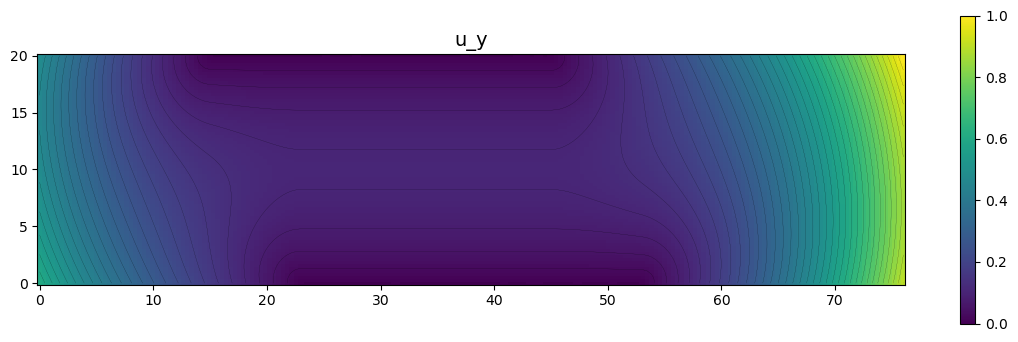

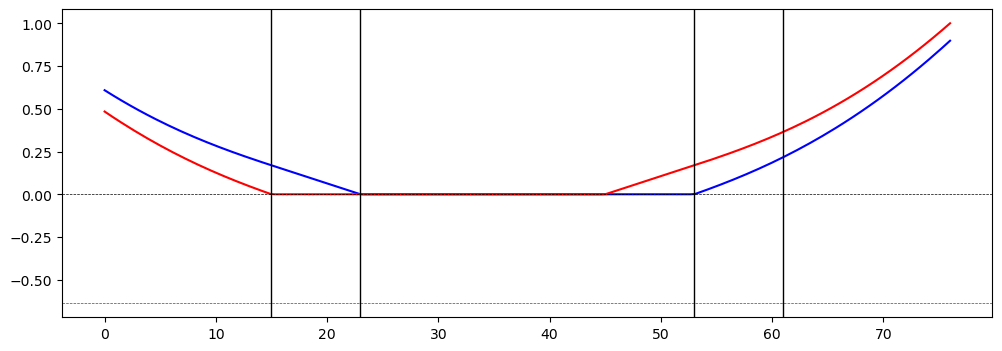

In [17]:
segs = [
    ((J1L, 0.0), (J1L+gauge, 0.0)), # bottom gauge
    ((J1S, w), (J1S+gauge, w)), # left top
]

uy_test = np.ones(X_grid.shape[0])
uy_hard_bc = uy_test * boundary_constraint_factor(X_grid[:, 0], X_grid[:, 1], segs, "C0+") 
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
im = pcolor_plot(ax, X, Y, uy_hard_bc.reshape(X.shape), "u_y")
# Plot the hard boundary condition
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(x_plot, uy_hard_bc.reshape(X.shape)[0,:], label='Top Boundary Condition', color='blue')
plt.plot(x_plot, uy_hard_bc.reshape(X.shape)[-1,:], label='Bottom Boundary Condition', color='red')
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.axhline(u_right, color='red', linestyle='--', linewidth=0.5)
ax.axvline(J1S, color='k', linestyle='-', linewidth=1)
ax.axvline(J1L, color='k', linestyle='-', linewidth=1)
ax.axvline(L - J2S, color='k', linestyle='-', linewidth=1)
ax.axvline(L - J2L, color='k', linestyle='-', linewidth=1)
plt.show()

